# 过拟合的限制方法——权重衰退(weight decay)
权重衰退是最广泛使用的正则化技术之一

使用均方范数作为柔性限制,
对每个θ,都可以找到λ使得之前的目标函数等价于下面:

![image.png](https://pic.rmb.bdstatic.com/bjh/c9199519530acbda053aa7691845d583.png)

在机器学习或者模式识别中，会出现overfitting，而当网络逐渐overfitting时网络权值逐渐变大，因此，为了避免出现overfitting,会给误差函数添加一个惩罚项，常用的惩罚项是所有权重的平方乘以一个衰减常量之和。其用来惩罚大的权值。

In [4]:
%matplotlib inline
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

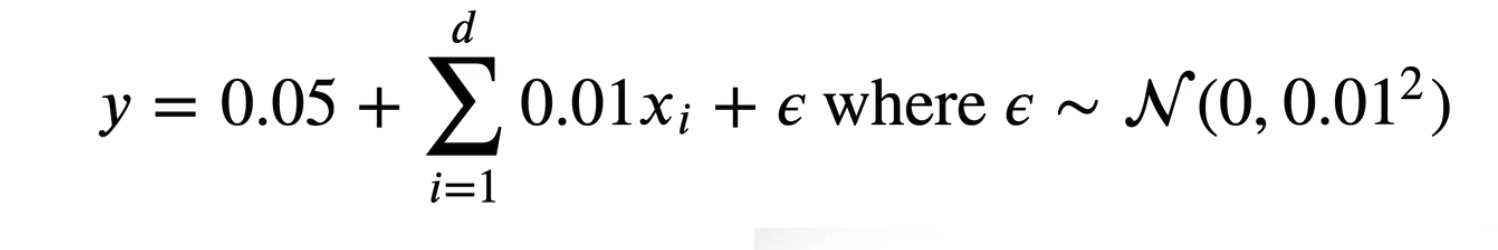

In [6]:
# 生成人工数据集
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [7]:
# 定义一个函数来随机初始化我们的模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义$L_2$范数惩罚

In [8]:
# 实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [10]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
#             with torch.enable_grad():
#                 # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.110771179199219


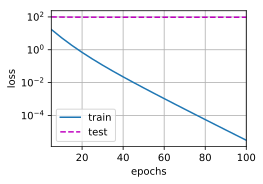

In [13]:
# 没有规约的时候
train(lambd=0)

结果过拟合

w的L2范数是： 0.3531966805458069


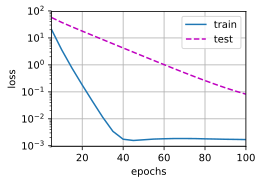

In [12]:
train(lambd=3)

## 简洁实现

In [19]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.147100448608398


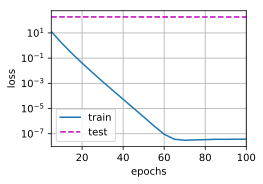

In [21]:
train_concise(0.01)